In [ ]:
from modelarts.session import Session
sess = Session()

if sess.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_face_facial_expression/facial_expression.tar"
elif sess.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_face_facial_expression/facial_expression.tar"
else:
    print("请更换地区到北京一或北京四")
    
sess.download_data(bucket_path=bucket_path, path="./facial_expression.tar")

!tar -xf facial_expression.tar

In [17]:
!pip install mtcnn

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,Dense,Activation,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from mtcnn.mtcnn import MTCNN


In [3]:
##元祖类型的
emotions = ('angry','disgust','fear','happy','sad','surprise','neutral')

In [4]:
num_classes = len(emotions)
batch_size = 16
epoch = 5

with open('./fer2013/fer2013.csv') as f:
    content = f.readlines()

lines = np.array(content)

Text(0.5,1,'angry')

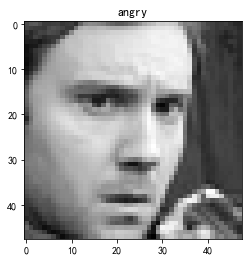

In [5]:
emotion_1,img_1,usage_1 = lines[1].split(',')
val_1 = img_1.split(' ')
pixels_1 = np.array(val_1,'float32')
aa = pixels_1.reshape(2304,1)
img = aa.reshape(int(2304**0.5),int(2304**0.5))
plt.imshow(img,plt.cm.gray)
plt.title(emotions[int(emotion_1)])

In [6]:
num_of_instances = lines.size
x_train,y_train,x_test,y_test = [],[],[],[]

for i in range(1,num_of_instances):
    try:
        emotion,img,usage = lines[i].split(',')
        val = img.split(' ')
        pixels = np.array(val,'float32')
        emotion = keras.utils.to_categorical(emotion,num_classes)
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print('',end='')

In [8]:
x_train = np.array(x_train,dtype='float32')
x_test = np.array(x_test,dtype='float32')
y_train = np.array(y_train,dtype='float32')
y_test = np.array(y_test,dtype='float32')
x_train = x_train/255
x_test = x_test/255
x_train.shape,x_test.shape

((28709, 2304), (3589, 2304))

In [9]:
x_train = x_train.reshape(len(x_train),48,48,1)
x_test = x_test.reshape(len(x_test),48,48,1)
print('num of train:',len(x_train))
print('num of test',len(x_test))

num of train: 28709
num of test 3589


In [10]:
gen = ImageDataGenerator()
train_generator  = gen.flow(x_train,y_train,batch_size=batch_size)

In [11]:
def build_model():
    model = Sequential()
    #1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model
    

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
model = build_model()
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.load_weights('./model/facial_expression_model_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='acc',min_delta=0.001,patience=4,mode='auto')
#md = ModelCheckpoint('表情监测one.h5',save_best_only=True)
callbacks = [es]
model.fit_generator(train_generator,steps_per_epoch=batch_size,epochs=100,callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
16/16 [==============================] - 1s 93ms/step - loss: 0.5929 - acc: 0.8086
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.9850 - acc: 0.7031
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 1.0789 - acc: 0.6992
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.9898 - acc: 0.6836
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.7542 - acc: 0.7344


### 看下模型预测效果

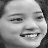

In [23]:
import cv2
img = cv2.cvtColor(cv2.imread('./img_nana_2.jpeg'),cv2.COLOR_BGR2RGB)
detector = MTCNN()
result = detector.detect_faces(img)
x,y,w,h = result[0]['box']
detected_face = img[int(y):int(y+h),int(x):int(x+w)]
detected_face = cv2.cvtColor(detected_face,cv2.COLOR_BGR2GRAY)
detected_face = cv2.resize(detected_face,(48,48))
Image.fromarray(detected_face)

In [24]:
img_pixels = detected_face.reshape(1,48,48,1)/255
predictions = model.predict(img_pixels)
result = emotions[predictions[0].argmax()]
result

'happy'

In [25]:
y_pred = model.predict(x_test)
acc = 0
for i in range(len(y_pred)):
    yy_pred = y_pred[i].argmax()
    yy_test = y_test[i].argmax()
    if yy_pred == yy_test:
        acc += 1
print('准确率为:{}%'.format(acc/len(y_pred)*100))

准确率为:52.382279186402904%
